##**Preparing** **Environment**

In [ ]:
!pip install yfinance --upgrade --no-cache-dir
!pip install plotly==4.13.0

     |████████████████████████████████| 5.5MB 9.6MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=94fbe8859c06609f8e0854369106d6af80f980db6e45f1bf1f86f0ead11a3dbd
  Stored in directory: /tmp/pip-ephem-wheel-cache-sy5fu_t6/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 13.1MB 12.1MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
#Importing Libraries
import yfinance as yf
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, Dropout, Input, Lambda, concatenate
from sklearn.metrics import mean_absolute_error
import pandas as pd
import plotly.graph_objects as go
tf.__version__

'2.4.0'

##**Importing data from yfinance**

In [ ]:
yf.pdr_override()
df = pdr.get_data_yahoo("0763.HK", start="2010-01-01", end="2021-01-01")
df = df[['Open','Low','High','Close','Adj Close','Volume']]

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.head()

,Open,Low,High,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,21.550900,21.5509,24.328699,24.074100,21.255974,9445248
2010-01-05,23.981501,23.8426,24.768499,24.722200,21.828207,5763522
2010-01-06,24.629601,23.7269,24.629601,23.981501,21.174213,3744619
2010-01-07,24.444401,23.0093,24.444401,23.263901,20.540619,3722224
2010-01-08,24.050900,23.4722,24.074100,24.050900,21.235487,2389586


##**History of Stock Price**

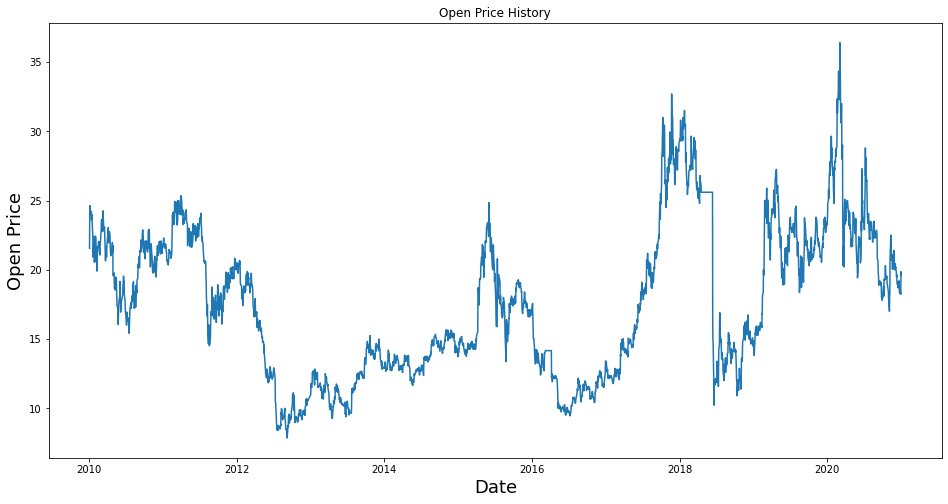

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Open Price History')
plt.plot(df[['Open']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price', fontsize=18)
plt.show()

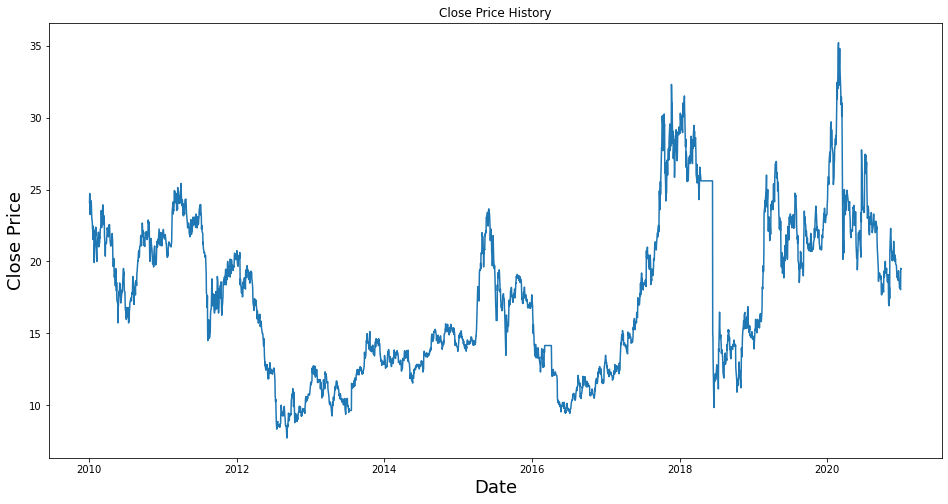

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df[['Close']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.show()


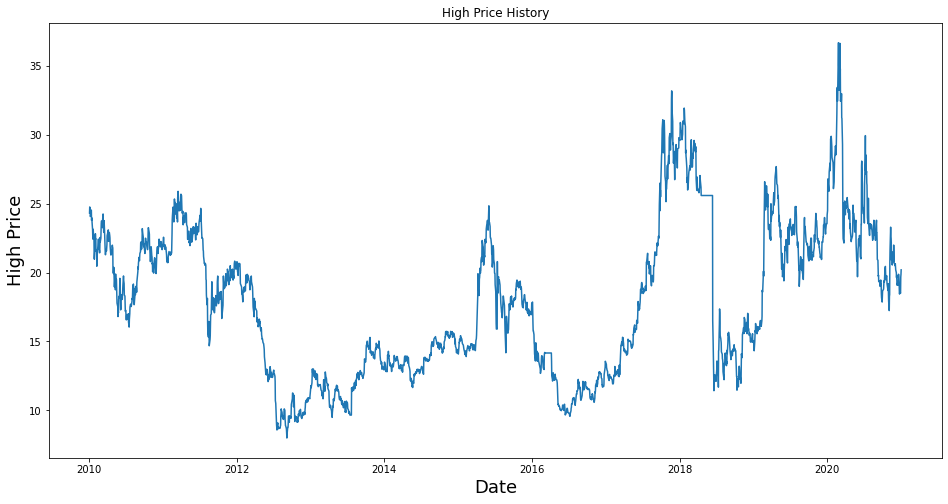

In [ ]:
plt.figure(figsize=(16,8))
plt.title('High Price History')
plt.plot(df[['High']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('High Price', fontsize=18)
plt.show()

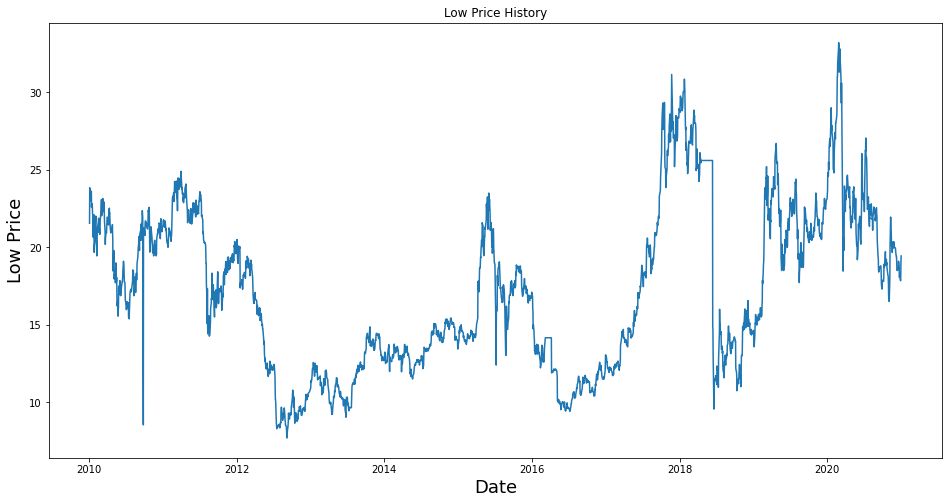

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Low Price History')
plt.plot(df[['Low']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Low Price', fontsize=18)
plt.show()

##**Scaling Data**

In [ ]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)
print(scaled_data.shape)

(2709, 6)


##**Preparing Dataset for Training** 

In [ ]:
#window size
WINDOW_SIZE = 20
TRAINING_DATA_LEN = int(scaled_data.shape[0]*0.75)

In [ ]:
#Create the scaled training data set
train_data = scaled_data[0:int(TRAINING_DATA_LEN), :]

#Split the data into x and y data sets
x = []
y = []

for i in range(WINDOW_SIZE, len(scaled_data)):
    x.append( scaled_data[i-WINDOW_SIZE:i,:4] )
    y.append( scaled_data[i,:] )

x_train = x[:TRAINING_DATA_LEN]
y_train = y[:TRAINING_DATA_LEN]
x_test = x[TRAINING_DATA_LEN:]
y_test = y[TRAINING_DATA_LEN:]

x_train,y_train = shuffle(x_train,y_train)

x_train, y_train, x_test, y_test = np.array(x_train),np.array(y_train),np.array(x_test),np.array(y_test)

x_train_open, x_test_open, y_train_open, y_test_open = x_train[:,:,0], x_test[:,:,0], y_train[:,0], y_test[:,0]

x_train_low, x_test_low, y_train_low, y_test_low = x_train[:,:,1], x_test[:,:,1], y_train[:,1], y_test[:,1]

x_train_high, x_test_high, y_train_high, y_test_high = x_train[:,:,2], x_test[:,:,2], y_train[:,2], y_test[:,2]

x_train_close, x_test_close, y_train_close, y_test_close = x_train[:,:,3], x_test[:,:,3], y_train[:,3], y_test[:,3]

y_test_open,y_test_low,y_test_high,y_test_close = np.expand_dims(y_test_open,axis=-1),np.expand_dims(y_test_low,axis=-1),np.expand_dims(y_test_high,axis=-1),np.expand_dims(y_test_close,axis=-1)

print('scaled_data shape:', scaled_data.shape,'\nx_train shape:',x_train.shape,'\ny_train shape:',y_train.shape,'\nx_test shape:',x_test.shape,'\ny_test shape:',y_test.shape)

scaled_data shape: (2709, 6) 
x_train shape: (2031, 20, 4) 
y_train shape: (2031, 6) 
x_test shape: (658, 20, 4) 
y_test shape: (658, 6)


##**Model Architecture**

In [ ]:
tf.compat.v1.reset_default_graph()

input_layer = Input(shape=(WINDOW_SIZE,1),ragged=True)

lstm11 = LSTM(10,return_sequences=False)(input_layer)

output1 = Dense(1,activation='sigmoid')(lstm11)
model_open = Model(inputs=input_layer, outputs=output1)


In [ ]:
tf.compat.v1.reset_default_graph()

input_layer = Input(shape=(WINDOW_SIZE,1),ragged=True)

lstm21 = LSTM(10,return_sequences=False)(input_layer)

output2 = Dense(1,activation='sigmoid')(lstm21)
model_high = Model(inputs=input_layer, outputs=output2)


In [ ]:
tf.compat.v1.reset_default_graph()

input_layer = Input(shape=(WINDOW_SIZE,1),ragged=True)

lstm31 = LSTM(10,return_sequences=False)(input_layer)

output3 = Dense(1,activation='sigmoid')(lstm31)
model_low = Model(inputs=input_layer, outputs=output3)


In [ ]:
tf.compat.v1.reset_default_graph()

input_layer = Input(shape=(WINDOW_SIZE,1),ragged=True)

lstm41 = LSTM(10,return_sequences=False)(input_layer)

output4 = Dense(1,activation='sigmoid')(lstm41)
model_close = Model(inputs=input_layer, outputs=output4)


In [ ]:
model_open.compile(optimizer="adam", loss="mse", metrics=["mse"])
model_high.compile(optimizer="adam", loss="mse", metrics=["mse"])
model_low.compile(optimizer="adam", loss="mse", metrics=["mse"])
model_close.compile(optimizer="adam", loss="mse", metrics=["mse"])
history_open = model_open.fit(x_train_open, y_train_open, epochs=100,batch_size=64,verbose=0)
print('finished training LSTM for open')
history_high = model_high.fit(x_train_high, y_train_high, epochs=100,batch_size=64, verbose=0)
print('finished training LSTM for high')
history_low = model_low.fit(x_train_low, y_train_low, epochs=100,batch_size=64, verbose=0)
print('finished training LSTM for low')
history_close = model_close.fit(x_train_close, y_train_close, epochs=100,batch_size=64, verbose=0)
print('finished training LSTM for close')

finished training LSTM for open
finished training LSTM for high
finished training LSTM for low
finished training LSTM for close


In [ ]:
lstm_train_open_mae = mean_absolute_error(model_open.predict(x_train_open),y_train_open)
lstm_train_open_acc = 1-lstm_train_open_mae
print('Open loss(MAE): ',lstm_train_open_mae)
print('Open Accuracy(1-MAE): ',lstm_train_open_acc)


lstm_train_high_mae = mean_absolute_error(model_high.predict(x_train_high),y_train_high)
lstm_train_high_acc = 1-lstm_train_high_mae
print('High loss(MAE): ',lstm_train_high_mae)
print('High Accuracy(1-MAE): ',lstm_train_high_acc)


lstm_train_low_mae = mean_absolute_error(model_low.predict(x_train_low),y_train_low)
lstm_train_low_acc = 1-lstm_train_low_mae
print('Low loss(MAE): ',lstm_train_low_mae)
print('Low Accuracy(1-MAE): ',lstm_train_low_acc)

lstm_train_close_mae = mean_absolute_error(model_close.predict(x_train_close),y_train_close)
lstm_train_close_acc = 1-lstm_train_close_mae
print('close loss(MAE): ',lstm_train_close_mae)
print('close Accuracy(1-MAE): ',lstm_train_close_acc)

Open loss(MAE):  0.016850343123838155
Open Accuracy(1-MAE):  0.9831496568761618
High loss(MAE):  0.015353690666484896
High Accuracy(1-MAE):  0.9846463093335152
Low loss(MAE):  0.018250955105955737
Low Accuracy(1-MAE):  0.9817490448940442
close loss(MAE):  0.016247024662539463
close Accuracy(1-MAE):  0.9837529753374605


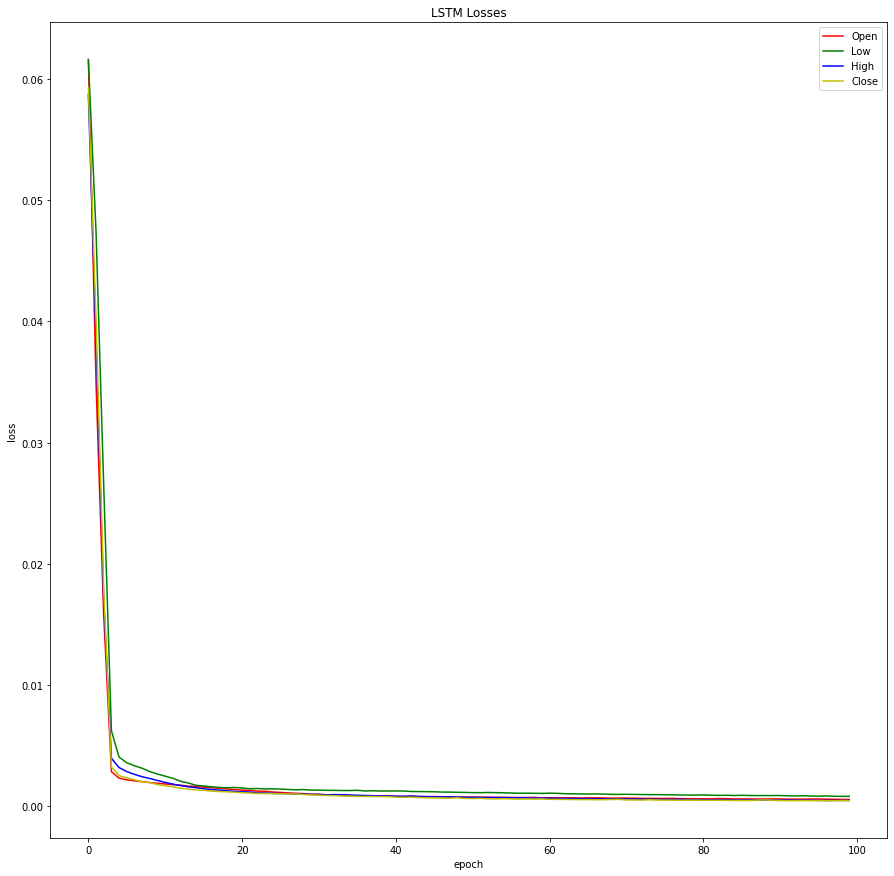

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(history_open.history['loss'],'r')
plt.plot(history_low.history['loss'],'g')
plt.plot(history_high.history['loss'],'b')
plt.plot(history_close.history['loss'],'y')
plt.title('LSTM Losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Open','Low','High','Close'], loc='upper right')

plt.show()

##**Predicting on Test Data**

In [ ]:
p_open = model_open.predict(x_test_open)
p_low = model_low.predict(x_test_low)
p_high = model_high.predict(x_test_high)
p_close = model_close.predict(x_test_close)

lstm_test_open_mae = mean_absolute_error(p_open,y_test_open)
lstm_test_open_acc = 1-lstm_test_open_mae
print('Open loss(MAE): ',lstm_test_open_mae)
print('Open Accuracy(1-MAE): ',lstm_test_open_acc)


lstm_test_high_mae = mean_absolute_error(p_high,y_test_high)
lstm_test_high_acc = 1-lstm_test_high_mae
print('High loss(MAE): ',lstm_test_high_mae)
print('High Accuracy(1-MAE): ',lstm_test_high_acc)


lstm_test_low_mae = mean_absolute_error(p_low,y_test_low)
lstm_test_low_acc = 1-lstm_test_low_mae
print('Low loss(MAE): ',lstm_test_low_mae)
print('Low Accuracy(1-MAE): ',lstm_test_low_acc)

lstm_test_close_mae = mean_absolute_error(p_close,y_test_close)
lstm_test_close_acc = 1-lstm_test_close_mae
print('close loss(MAE): ',lstm_test_close_mae)
print('close Accuracy(1-MAE): ',lstm_test_close_acc)

Open loss(MAE):  0.02831473966783695
Open Accuracy(1-MAE):  0.9716852603321631
High loss(MAE):  0.027272497976967697
High Accuracy(1-MAE):  0.9727275020230323
Low loss(MAE):  0.03252893743739052
Low Accuracy(1-MAE):  0.9674710625626095
close loss(MAE):  0.02580544312177851
close Accuracy(1-MAE):  0.9741945568782215


In [ ]:
#Rescaling
ptemp = np.concatenate([p_open,p_low,p_high,p_close,scaled_data[TRAINING_DATA_LEN+WINDOW_SIZE:,4:]],axis=1)
ytemp = np.concatenate([y_test_open,y_test_low,y_test_high,y_test_close,scaled_data[TRAINING_DATA_LEN+WINDOW_SIZE:,4:]],axis=1)
p_rescaled = scaler.inverse_transform(ptemp)
y_rescaled = scaler.inverse_transform(ytemp)

In [ ]:
p_rescaled.shape

(658, 6)

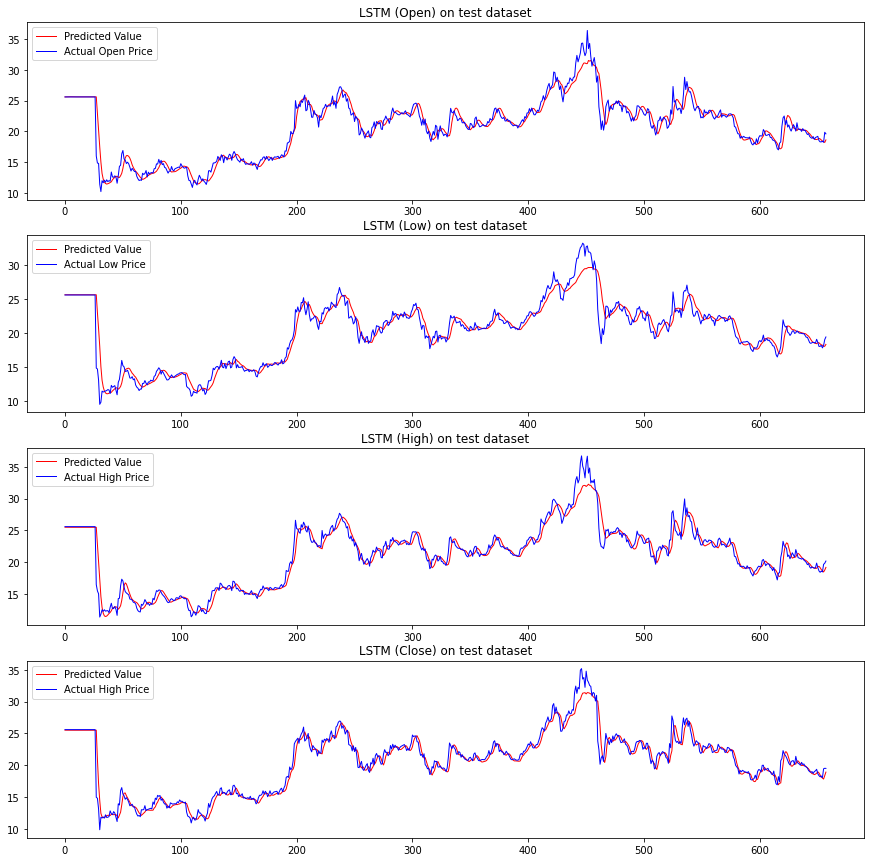

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(p_rescaled[:,0],'r',linewidth=1)
plt.plot(y_rescaled[:,0],'b',linewidth=1)
plt.title('LSTM (Open) on test dataset')
plt.legend(['Predicted Value', 'Actual Open Price'], loc='upper left')
plt.subplot(412)
plt.plot(p_rescaled[:,1],'r',linewidth=1)
plt.plot(y_rescaled[:,1],'b',linewidth=1)
plt.title('LSTM (Low) on test dataset')
plt.legend(['Predicted Value', 'Actual Low Price'], loc='upper left')
plt.subplot(413)
plt.plot(p_rescaled[:,2],'r',linewidth=1)
plt.plot(y_rescaled[:,2],'b',linewidth=1)
plt.title('LSTM (High) on test dataset')
plt.legend(['Predicted Value', 'Actual High Price'], loc='upper left')
plt.subplot(414)
plt.plot(p_rescaled[:,3],'r',linewidth=1)
plt.plot(y_rescaled[:,3],'b',linewidth=1)
plt.title('LSTM (Close) on test dataset')
plt.legend(['Predicted Value', 'Actual High Price'], loc='upper left')
plt.show()

##**Forecasting with LSTM**

In [ ]:
PRED_DAYS = 30

In [ ]:
dt_index = list(df.index[TRAINING_DATA_LEN+WINDOW_SIZE:])

In [ ]:
#fp = associated_net.predict(x_test)
fp = np.concatenate((model_open.predict(x_test_open),model_low.predict(x_test_low),
               model_high.predict(x_test_high),model_close.predict(x_test_close)),axis=-1)

for i in range(PRED_DAYS):
  window = fp[-1 * WINDOW_SIZE:,:]
  window = np.reshape(window,(1,WINDOW_SIZE,-1))
  prediction = np.concatenate((model_open.predict(window[:,:,0]),model_low.predict(window[:,:,1]),
               model_high.predict(window[:,:,2]),model_close.predict(window[:,:,3])),axis=-1)
  fp = np.append(fp,prediction,axis=0)
  dt_index.append(pd.DateOffset(1)+dt_index[-1])

print(fp.shape)

(688, 4)


In [ ]:
y_test.shape

(658, 6)

In [ ]:
#Rescaling
ptemp = np.concatenate([fp,scaled_data[:len(fp),4:]],axis=1)
#ytemp = np.concatenate([y_test,scaled_data[TRAINING_DATA_LEN+WINDOW_SIZE:,:]],axis=1)
ytemp = np.copy(y_test)
p_rescaled = scaler.inverse_transform(ptemp)
y_rescaled = scaler.inverse_transform(ytemp)

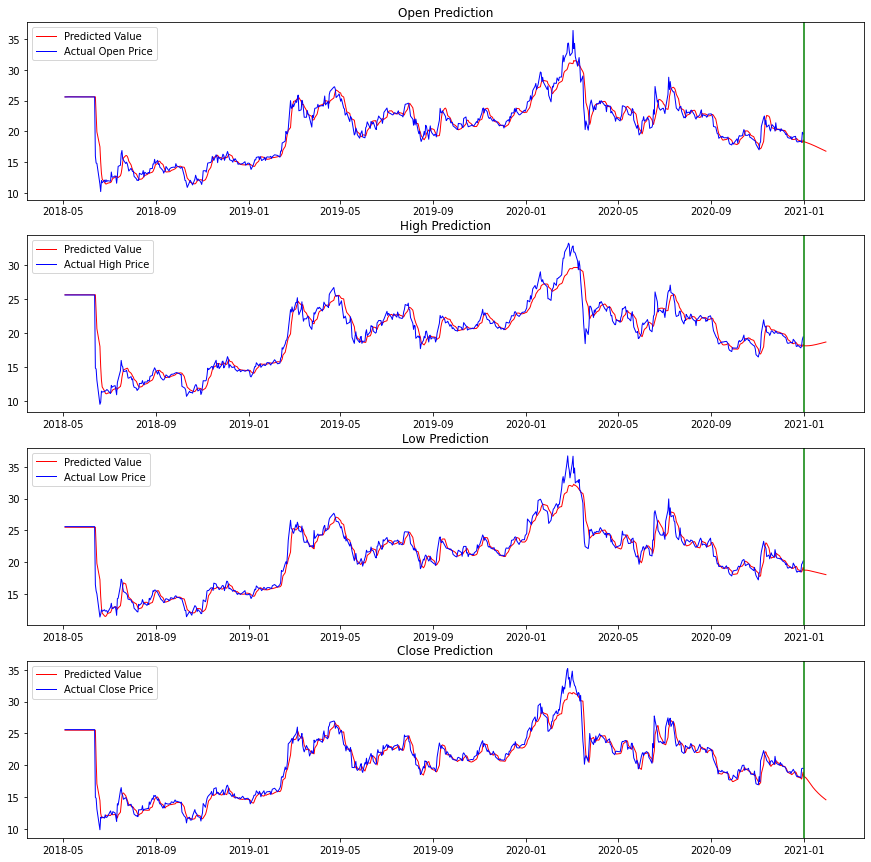

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(dt_index,p_rescaled[:,0],color='r',linewidth=1)
plt.plot(dt_index[:len(y_rescaled)],y_rescaled[:,0],color='b',linewidth=1)
plt.axvline(x=dt_index[len(y_rescaled)],color='green')
plt.title('Open Prediction')
plt.legend(['Predicted Value', 'Actual Open Price'], loc='upper left')
plt.subplot(412)
plt.plot(dt_index,p_rescaled[:,1],'r',linewidth=1)
plt.plot(dt_index[:len(y_rescaled)],y_rescaled[:,1],'b',linewidth=1)
plt.axvline(x=dt_index[len(y_rescaled)],color='green')
plt.title('High Prediction')
plt.legend(['Predicted Value', 'Actual High Price'], loc='upper left')
plt.subplot(413)
plt.plot(dt_index,p_rescaled[:,2],'r',linewidth=1)
plt.plot(dt_index[:len(y_rescaled)],y_rescaled[:,2],'b',linewidth=1)
plt.axvline(x=dt_index[len(y_rescaled)],color='green')
plt.title('Low Prediction')
plt.legend(['Predicted Value', 'Actual Low Price'], loc='upper left')
plt.subplot(414)
plt.plot(dt_index,p_rescaled[:,3],'r',linewidth=1)
plt.plot(dt_index[:len(y_rescaled)],y_rescaled[:,3],'b',linewidth=1)
plt.axvline(x=dt_index[len(y_rescaled)],color='green')
plt.title('Close Prediction')
plt.legend(['Predicted Value', 'Actual Close Price'], loc='upper left')
plt.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=dt_index, y=p_rescaled[:,0],
                      name='predicted_open',
                      marker=dict(size=1),
                      line = dict(color='red',width=1)
                      #mode="markers",
                  ))

fig.add_trace(go.Scatter(x=dt_index, y=p_rescaled[:,1],
                      name='predicted_low',
                      marker=dict(size=1),
                      line = dict(color='red',width=1)
                      #mode="markers",
                  ))

fig.add_trace(go.Scatter(x=dt_index, y=p_rescaled[:,2],
                      name='predicted_high',
                      marker=dict(size=1),
                      line = dict(color='red',width=1)
                      #mode="markers",
                  ))

fig.add_trace(go.Scatter(x=dt_index, y=p_rescaled[:,3],
                      name='predicted_close',
                      marker=dict(size=1),
                      line = dict(color='red',width=1)
                      #mode="markers"
                  ))


fig.add_trace(go.Scatter(x=dt_index, y=y_rescaled[:,0],
                      name='actual_open',
                      marker=dict(size=1),
                      line = dict(color='blue',width=1)
                      #mode="markers",
                  ))

fig.add_trace(go.Scatter(x=dt_index, y=y_rescaled[:,1],
                      name='actual_low',
                      marker=dict(size=1),
                      line = dict(color='blue',width=1)
                      #mode="markers",
                  ))

fig.add_trace(go.Scatter(x=dt_index, y=y_rescaled[:,2],
                      name='actual_high',
                      marker=dict(size=1),
                      line = dict(color='blue',width=1)
                      #mode="markers",
                  ))

fig.add_trace(go.Scatter(x=dt_index, y=y_rescaled[:,3],
                      name='actual_close',
                      marker=dict(size=1),
                      line = dict(color='blue',width=1)
                      #mode="markers",
                  ))

fig.add_vline(x='2021-01-01', line_width=3, line_dash="dash", line_color="green", name='current date')
fig.update_layout(
    title='Shanghai Index',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)
fig.write_html('sample.html')
fig.show()